# Urn problem

Suppose you have an urn with a large number of balls, some of which are red balls and some white. 

You draw a ball from the urn, note its colour and replace it in the urn. (The replacement means that the draws are independent, i.e. the previous draws do not affect the current one). 

Let us assume a red ball is a "success". 
Let the fraction of red balls in the urn be denoted $\rho$.

The probability of getting $r$ successes from $n$ trials is given by the [binomial probability distribution](https://en.wikipedia.org/wiki/Binomial_distribution)

In [1]:
%matplotlib inline
from pylab import *

def binom(trials,success,p):
        
    import scipy.special as sp
    # Prefactor sp.binom (the binomial coefficient) returns (trials)!/(success! * (trials-success)!)
    return sp.binom(trials, success)*p**success*(1.-p)**(trials-success)



3 trials


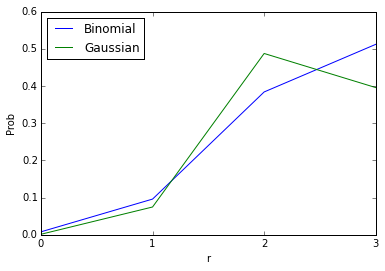

In [2]:
from scipy.stats import norm

def plotbinom(rho, trials):
    
    # Its also interesting to plot the Gaussian approximation to the binomial distribution
    mean = trials*rho
    sd =sqrt (trials * rho * ( 1. - rho ))
    # Gaussian distribution from scipy.stats
    rv = norm(loc = mean, scale = sd)

    r = np.linspace(0.,trials, trials+1)
    plot(r, binom(trials, r, rho),label='Binomial')
    plot(r, rv.pdf(r), label='Gaussian')
    legend(loc='upper left')
    xlabel('r')
    ylabel('Prob')
    print trials, "trials"
    
rho = 0.8
xticks(np.arange(0.,4.,1.0))
plotbinom(rho, 3)

So there are four possibilities for the number of red balls, $r$: 0, 1, 2, 3.  Probability of $r=0$ is very low because I would have to pull a white ball 3 times in a row.


### Aside: 

In the plot above the green and blue curves are different.

But what happens if we crank up the number of trial, to, say, 100?


100 trials


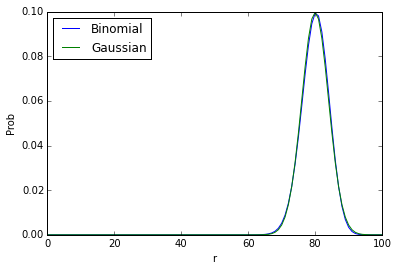

In [3]:
plotbinom(rho, 100)


The distribution approaches a Gaussian (or "normal") shape! 

This is a consequence of the *central limit theorem*. 

We are adding random variables. In this case the random variables are discrete: P=0.8 red (1) or P=0.2 white (0). In the limit that the number of things being added is large, you get a Gaussian shape. The remarkable thing is that it doesn't matter what is the probability distribution of the underlying variable that you are adding.

And since *means* are just sums over all the data (divided by a constant), they follow the central limit theorem if the number of data being averaged is large.

### Back to the main story

So this tells us the probability of getting $r$ successes from $n$ trials. Which is fine. But in science its not what we want ....

---

What we really want to know is the **not** the probability of getting the number of red balls that we actually observed but, rather, given the number of red balls that we pulled (the sample),  what is the fraction of red balls in the urn (the population).

(The red balls pulled are the data ,and the fraction of red balls in the urn $\rho$ is the unknown model parameter).

This was considered by Jacob Bernoulli, and published in [1713](https://en.wikipedia.org/wiki/Ars_Conjectandi).

Suppose you draw a ball 5 times (5 "trials") and the number of reds ("successes") is 4. 

Turn the problem around and consider which choice of $\rho$ maximizes the probability of the observed outcome. Now $\rho$ is the variable, and the numbers of trials and successes are fixed.  


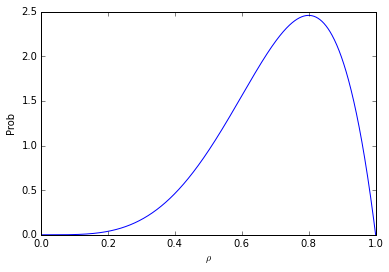

In [4]:
def getrho(trials, success, drho = 0.001):

    rho = np.linspace(0.,1.,int(1./drho))
    drho = rho[1]-rho[0]
    
    prob = binom(trials, success, rho)
    # Normalize it and convert to probability *density*
    prob = prob/np.sum(prob)/drho
    
    return prob, rho
    
def plotrho(trials, success):
    
    prob, rho = getrho(trials, success)

    xlabel(r'$\rho$')
    ylabel('Prob')
    plot(rho, prob);
    return

success = 4
trials = 5
plotrho(trials, success)

The fact that the peak is at 0.8 may seem obvious. But what is less obvious is that $\rho = 0.5$ is only a little less likely. So you can determine confidence intervals on $\rho$.

Notice that when $\rho$ is a continuous variable it only makes sense to talk about the probability of an *interval* of $\rho$. For example, the probability that $\rho$ is between $0.79$ and $0.81$ is $\approx 2.5 \times 0.02 = 0.05$. 

In [5]:
def prob_int(trials, success, lo, hi):

    from scipy.interpolate import interp1d
    
    prob, rho  = getrho(trials, success)
    drho = rho[1]-rho[0]
    sumprob = cumsum(prob)*drho
    f = interp1d(rho, sumprob)
    return f(hi)-f(lo)

print "Probability that rho is between 0.79 and 0.81:", prob_int(5, 4, 0.79,0.81)
print "Probability that rho is 0.8 or greater       :", prob_int(5, 4, 0.8,1.)
print "Probability that rho is 0.8 or less          :", prob_int(5, 4, 0.,0.8);


Probability that rho is between 0.79 and 0.81: 0.0491261717069
Probability that rho is 0.8 or greater       : 0.343408329527
Probability that rho is 0.8 or less          : 0.656591670473


What if we had pulled *all* red balls?

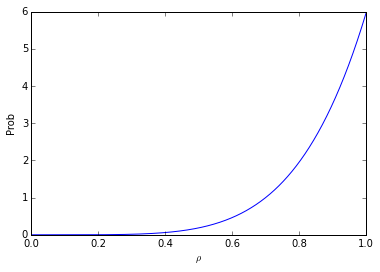

In [6]:
success=5
trials=5

plotrho(trials, success)

If we only make one trial, we don't learn too much!

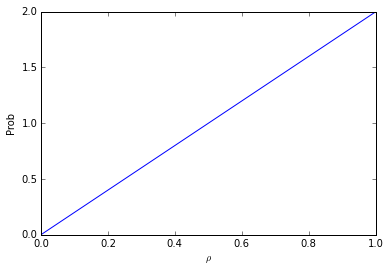

In [7]:
success=1
trials=1

plotrho(trials, success)

If we do many draws (trials) our confidence in $\rho$ increases, i.e. the probability distribution narrows.

Probability that rho is between 0.79 and 0.81: 0.141865671089


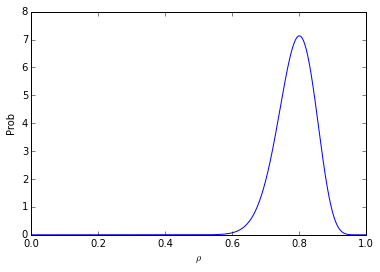

In [8]:
success=40
trials=50

plotrho(trials, success);

print "Probability that rho is between 0.79 and 0.81:", prob_int(trials, success, 0.79,0.81)


Now let's really crank it way up.

Probability that rho is between 0.79 and 0.81: 0.622638804123


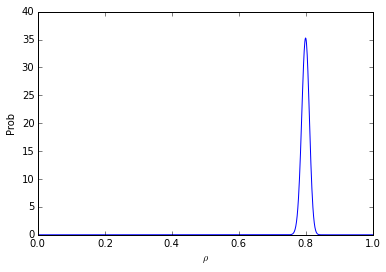

In [9]:
success=1000
trials=1250

plotrho(trials, success);

print "Probability that rho is between 0.79 and 0.81:", prob_int(trials, success, 0.79, 0.81)


This is roughly the 68% confidence interval of $\rho$, i.e. $\rho = 0.80\pm0.01$ for 1250 trials.

---

Its also fine if the urn contains only a finite number of balls (say 10). Then the value of $\rho$ can only take on discrete values (in this example steps of 0.1).

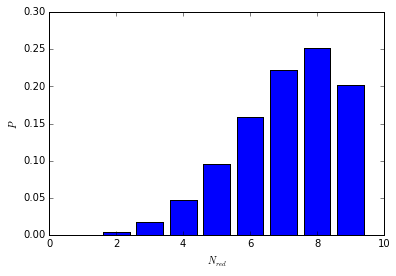

In [10]:
success = 4
trials = 5

nred  = np.linspace(0.,10.,11.)

rho = nred/10.
prob = binom(trials,success, rho)
# We are now plotting probability per bin, not probability density
prob = prob/np.sum(prob)

# Let's plot as a histogram
# Note that by default the first argument (nred) is assumed to represent the left edge of teh bin.
# So we use align='center'

xlim((0,10))
xlabel(r'$N_{red}$')
ylabel(r'$P$')

bar(nred,prob, align='center');

Implicit in all of the above is what is called a *flat prior* on $\rho$.

In other words we do not make an prior assumptions on $\rho$.

Suppose a spy had told us "I saw at least 2 white balls placed in the urn. There could be more, but there are at least 2". We now have a *prior* on $N_{red}$. It is between 0 and 8 (can't be 9 or 10 since there are a minimum of 2 white balls). Since we don't know anything else about the number of red balls (or white) we might assume that all remaining possibilities are equally likely.


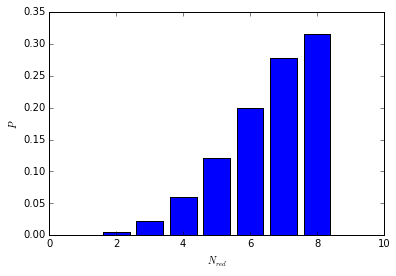

In [11]:
success = 4
trials = 5

nred  = linspace(0.,10.,11.)

rho = nred/10.
prob = binom(trials,success, rho)
# Renormalize so that we integrate only from 0 to 8.
prob = where(nred <=8, prob/sum(prob[:9]), 0.)

xlabel(r'$N_{red}$')
ylabel(r'$P$')
xlim(0,10)
bar(nred,prob, align='center');

The prior has changed the probability distribution, eliminating 9 as a possibility, and boosting all other values.

This may seem trivial, but in real physical situations it can be important. For example, we may expect the mass of an object to be positive or zero, but not negative. We have a prior on mass.